In [1]:
import numpy as np
import pandas as pd

from nilearn.maskers import MultiNiftiLabelsMasker, MultiNiftiMapsMasker
from nilearn.image import resample_to_img, math_img, concat_imgs, smooth_img

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf
import statsmodels.api as sm

In [2]:
rois = ["EVC", "FG", "LOC", "DMN", 'FPN', "Dorsal"]
roi_imgs = [f"/Users/chris/projects/Nature2023MooneyScripts/results/clumped_rois/{roi}.nii.gz" for roi in rois]
roi_imgs = [resample_to_img(roi_img, "/Users/chris/projects/Nature2023MooneyScripts/results/clumped_rois/EVC.nii.gz") for roi_img in roi_imgs]
roi = concat_imgs(roi_imgs)
roi_map = math_img("np.where(img.max(-1) > 0.5, img.argmax(-1) + 1, 0)", img=roi)

/opt/anaconda3/envs/nature2023/lib/python3.11/site-packages/nilearn/image/image.py:1071: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)


In [3]:
subjects = [11, 4, 6, 7, 8, 9, 10, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25]
record = {
    "subject": [],
    "roi": [],
    "image_index": [],
    "weights": []
}

subject_files = [f"/Users/chris/projects/Nature2023MooneyScripts/results/prediction_error/counterfactual:post-post/subject{s}.nii.gz" for s in subjects]

masked_data = MultiNiftiLabelsMasker(labels_img=roi_map, standardize=False, strategy="median").fit_transform(subject_files)

for subject, subject_data in zip(subjects, masked_data):
    for image_index in range(33):
        for roi_idx, roi in enumerate(rois):
            record["subject"].append(subject)
            record["roi"].append(roi)
            record["image_index"].append(image_index)
            record["weights"].append(subject_data[image_index, roi_idx])

orig_df = pd.DataFrame(record)

In [4]:
orig_df = pd.DataFrame(record)

In [5]:
# Load one fmri sequence to get the labels
fmri_sequence = pd.read_csv("/Users/chris/projects/Nature2023MooneyScripts/results/fmri_sequences/human_subject4.csv")

# Make a conversion
index_to_image_name = {}
for i, row in fmri_sequence.iterrows():
    index_to_image_name[row["image_index"]] = row["image_path"].split("/")[-1]

In [6]:
for (subject, image_index), small_df in orig_df.groupby(["subject", "image_index"]):
    # Load the response order
    df_subject = pd.read_excel(f"/Users/chris/projects/Nature2023MooneyScripts/data/fmri_image_order/S{subject}/response_order.xlsx", header=None, names=["image_name", "image_recognized"])

    # Get the image name
    img_name_this = index_to_image_name[image_index]

    # Match with the first row with this image name
    first_row = df_subject[df_subject["image_name"] == img_name_this]

    # Some names are missing a 1
    if len(first_row) == 0:
        img_name_this = img_name_this.replace(".bmp", "1.bmp")
        first_row = df_subject[df_subject["image_name"] == img_name_this]

    recs = first_row["image_recognized"].values

    # Replace any condition not 0 or 1 as 0
    recs = np.where(recs > 1, 0, recs)

    rec_pre = recs[:len(recs) // 2].mean() >= 4/6
    unrec_pre = recs[:len(recs) // 2].mean() <= 2/6

    rec_post = recs[len(recs) // 2:].mean() >= 4/6
    unrec_post = recs[len(recs) // 2:].mean() <= 2/6

    index = small_df.index

    orig_df.loc[index, "reliability"] = recs[len(recs) // 2:].mean()
    if unrec_pre and unrec_post:
        orig_df.loc[index, "learning"] = 0
    elif unrec_pre and rec_post:
        orig_df.loc[index, "learning"] = 1
    else:
        if rec_pre:
            orig_df.loc[index, "learning"] = 100
            orig_df.loc[index, "reliability"] = -1
        else:
            # This is not learned, and not unlearned, and not recognized before.
            orig_df.loc[index, "learning"] = -1

In [7]:
orig_df["learning"].value_counts()

 1.0      1650
 100.0    1584
 0.0       330
-1.0       198
Name: learning, dtype: int64

## OK

In [8]:
df = orig_df.copy()

In [9]:
# Turn long into wide: component_value_0, component_value_1, component_value_2, becomes columns
df_rotate = pd.pivot_table(df, index=["subject", "image_index", "learning"], columns="roi", values="weights").reset_index()

In [10]:
from pingouin import pairwise_corr
from scipy.stats import false_discovery_control, wilcoxon

In [11]:
def get_plot(df_this, condition, df_pre_rotate):
    rois = df_pre_rotate["roi"].unique().tolist()
    df_this = df_this.copy()

    corr = np.zeros((len(rois), len(rois), len(df_this["subject"].unique())))
    for subj_idx, (subject, small_df) in enumerate(df_this[df_this["learning"]==condition].groupby("subject")):
        if len(small_df) <= 3:
            corr[:, :, subj_idx] = np.nan
            continue

        results = pairwise_corr(small_df, columns=rois, method="spearman")

        for idx, row in results.iterrows():
            corr[rois.index(row["Y"]), rois.index(row["X"]), subj_idx] = row["r"]
            corr[rois.index(row["X"]), rois.index(row["Y"]), subj_idx] = row["r"]

    # Get the lower triangle
    vals = []
    for i in range(len(rois)):
        for j in range(i):
            stats = corr[i, j, :]
            vals.append(wilcoxon(stats[~np.isnan(stats)]))
    p_vals = false_discovery_control([v[1] for v in vals], method="by").tolist()

    p_mat = np.zeros((len(rois), len(rois)))
    for i in range(len(rois)):
        for j in range(i):
            val = p_vals.pop(0)
            p_mat[i, j] = val
            p_mat[j, i] = val

    return corr, p_mat, rois

In [12]:
learned_mat, learned_p, rois = get_plot(df_rotate, 1, df)

/opt/anaconda3/envs/nature2023/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  res = hypotest_fun_out(*samples, **kwds)


/var/folders/js/6gw33t_51rqcvbmgmlr5ybtw0000gn/T/ipykernel_20703/4031674764.py:9: RuntimeWarning: All-NaN slice encountered
  heatmap1 = sns.heatmap(np.nanmedian(this_coef, axis=-1), cmap="coolwarm", vmin=-1, vmax=1, cbar=False, ax=axis)


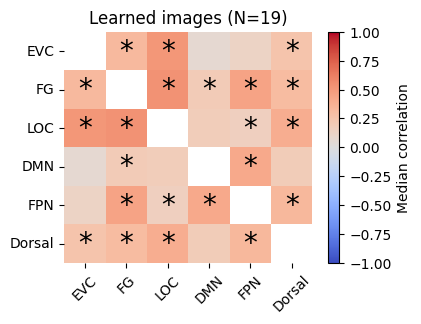

In [18]:
fig, axis = plt.subplots(1, 1, figsize=(4, 3))

this_coef = learned_mat.copy()
p_mat = learned_p.copy()
this_name = "Learned"

# Set the diagonal to nan
this_coef[np.eye(len(rois), dtype=bool)] = np.nan
heatmap1 = sns.heatmap(np.nanmedian(this_coef, axis=-1), cmap="coolwarm", vmin=-1, vmax=1, cbar=False, ax=axis)

# Number of images
n_imgs = (~np.isnan(this_coef[0, 1, :])).sum()

for i in range(p_mat.shape[1]):
    for j in range(p_mat.shape[0]):
        if np.isnan(p_mat[i, j]) or i == j:
            continue

        if p_mat[i, j] < 0.05:
            axis.text(i+0.5, j+0.5, "*", ha='center', va='center', color="black", fontsize=20)

axis.set_title(f"{this_name} images (N={n_imgs})")
axis.set_ylabel("")
axis.set_xlabel("")

# Set the ticks
axis.set_xticks(ticks=np.arange(len(rois)) + 0.5, labels=rois, rotation=45)
axis.set_yticks(ticks=np.arange(len(rois)) + 0.5, labels=rois, rotation=0)

# Create a colorbar to the right without being in 2nd axis
plt.colorbar(heatmap1.get_children()[0], ax=axis, orientation='vertical', label="Median correlation")

## Model connection shrinkage

In [28]:
connection_df = {"connection": [], "subject": [], "corr": []}
for i in range(6):
    for j in range(i):
        for idx, s in enumerate(learned_mat[i, j, :]):
            if np.isnan(s):
                continue

            connection_df["connection"].append(f"{rois[i]}-{rois[j]}")
            connection_df["subject"].append(idx)
            connection_df["corr"].append(s)

connection_df = pd.DataFrame(connection_df)

res = smf.gee("corr ~ C(connection)", data=connection_df, groups="subject").fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                        corr   No. Observations:                  285
Model:                                 GEE   No. clusters:                       19
Method:                        Generalized   Min. cluster size:                  15
                      Estimating Equations   Max. cluster size:                  15
Family:                           Gaussian   Mean cluster size:                15.0
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Thu, 30 May 2024   Scale:                           0.084
Covariance type:                    robust   Time:                         11:28:05
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       0.0737      0.060      1.234      0.217      -0.043       0.191
C(connection)[T.DMN-FG]         0.1292      0.067      1.920      0.055      -0.003       0.261
C(connection)[T.DMN-LOC]        0.0707      0.085      0.834      0.404      -0.095       0.237
C(connection)[T.Dorsal-DMN]     0.0750      0.082      0.919      0.358      -0.085       0.235
C(connection)[T.Dorsal-EVC]     0.1812      0.073      2.475      0.013       0.038       0.325
C(connection)[T.Dorsal-FG]      0.2078      0.097      2.132      0.033       0.017       0.399
C(connection)[T.Dorsal-FPN]     0.2399      0.073      3.271      0.001       0.096       0.384
C(connection)[T.Dorsal-LOC]     0.2744      0.080      3.434      0.001       0.118       0.431
C(connection)[T.FG-EVC]         0.2433      0.070      3.488      0.000       0.107       0.380
C(connection)[T.FPN-DMN]        0.3161      0.086      3.674      0.000       0.147       0.485
C(connection)[T.FPN-EVC]        0.0616      0.067      0.919      0.358      -0.070       0.193
C(connection)[T.FPN-FG]         0.3518      0.088      4.002      0.000       0.180       0.524
C(connection)[T.FPN-LOC]        0.1201      0.090      1.337      0.181      -0.056       0.296
C(connection)[T.LOC-EVC]        0.3177      0.070      4.564      0.000       0.181       0.454
C(connection)[T.LOC-FG]         0.3252      0.096      3.398      0.001       0.138       0.513
==============================================================================
Skew:                         -0.4533   Kurtosis:                      -0.1323
Centered skew:                 0.0886   Centered kurtosis:             -0.1087
==============================================================================
"""

In [29]:
m2_df = {'Connection': [], 'coef': [], 'ci_low': [], 'ci_high': [], 'p': []}
connections = ["DMN-FG", "DMN-LOC", "Dorsal-DMN", "Dorsal-EVC", "Dorsal-FG", "Dorsal-FPN", "Dorsal-LOC", "FG-EVC", "FPN-DMN", "FPN-EVC", "FPN-FG", "FPN-LOC", "LOC-EVC", "LOC-FG"]
starting_idx = 1
for roi_idx, conn in zip(range(starting_idx, len(connections) + starting_idx), connections):
    m2_df["Connection"].append(conn)

    m2_df["ci_low"].append(res.conf_int().iloc[roi_idx, 0])
    m2_df["ci_high"].append(res.conf_int().iloc[roi_idx, 1])
    m2_df["coef"].append(res.params[roi_idx])
    m2_df["p"].append(res.pvalues[roi_idx])

m2_df = pd.DataFrame(m2_df)
m2_df["q"] = false_discovery_control(m2_df["p"])
m2_df[m2_df["q"] < 0.05]

,Connection,coef,ci_low,ci_high,p,q
3,Dorsal-EVC,0.181179,0.037674,0.324684,0.013342,0.023348
5,Dorsal-FPN,0.239939,0.096174,0.383704,0.001071,0.002143
6,Dorsal-LOC,0.274395,0.117762,0.431029,0.000596,0.001585
7,FG-EVC,0.243327,0.106591,0.380063,0.000487,0.001585
8,FPN-DMN,0.316143,0.147488,0.484799,0.000239,0.001115
10,FPN-FG,0.351811,0.179508,0.524114,0.000063,0.000440
12,LOC-EVC,0.317657,0.181246,0.454067,0.000005,0.000070
13,LOC-FG,0.325169,0.137599,0.512739,0.000679,0.001585


In [30]:
m2_df.to_dict()

{'Connection': {0: 'DMN-FG',
  1: 'DMN-LOC',
  2: 'Dorsal-DMN',
  3: 'Dorsal-EVC',
  4: 'Dorsal-FG',
  5: 'Dorsal-FPN',
  6: 'Dorsal-LOC',
  7: 'FG-EVC',
  8: 'FPN-DMN',
  9: 'FPN-EVC',
  10: 'FPN-FG',
  11: 'FPN-LOC',
  12: 'LOC-EVC',
  13: 'LOC-FG'},
 'coef': {0: 0.1292268354013991,
  1: 0.07066980224749357,
  2: 0.07500617288468757,
  3: 0.18117887008767974,
  4: 0.20783952957560586,
  5: 0.23993906815750743,
  6: 0.2743952399171876,
  7: 0.24332674467863896,
  8: 0.3161434529020064,
  9: 0.06158290541669848,
  10: 0.35181079081121724,
  11: 0.12012604434462594,
  12: 0.3176565077198187,
  13: 0.3251694239092465},
 'ci_low': {0: -0.002695337335729603,
  1: -0.09547673657774276,
  2: -0.08487915769326022,
  3: 0.037674115361833765,
  4: 0.016757416551640814,
  5: 0.09617386331304245,
  6: 0.11776162860010173,
  7: 0.1065906329107178,
  8: 0.1474878137730391,
  9: -0.06973905403010028,
  10: 0.17950761593707054,
  11: -0.05601225615266596,
  12: 0.18124592105567822,
  13: 0.1375993980

### Unlearned

/opt/anaconda3/envs/nature2023/lib/python3.11/site-packages/pingouin/power.py:861: UserWarning: Sample size is too small to estimate power (n <= 4). Returning NaN.
  warnings.warn("Sample size is too small to estimate power (n <= 4). Returning NaN.")
/opt/anaconda3/envs/nature2023/lib/python3.11/site-packages/pingouin/power.py:861: UserWarning: Sample size is too small to estimate power (n <= 4). Returning NaN.
  warnings.warn("Sample size is too small to estimate power (n <= 4). Returning NaN.")
/opt/anaconda3/envs/nature2023/lib/python3.11/site-packages/pingouin/power.py:861: UserWarning: Sample size is too small to estimate power (n <= 4). Returning NaN.
  warnings.warn("Sample size is too small to estimate power (n <= 4). Returning NaN.")
/opt/anaconda3/envs/nature2023/lib/python3.11/site-packages/pingouin/power.py:861: UserWarning: Sample size is too small to estimate power (n <= 4). Returning NaN.
  warnings.warn("Sample size is too small to estimate power (n <= 4). Returning NaN

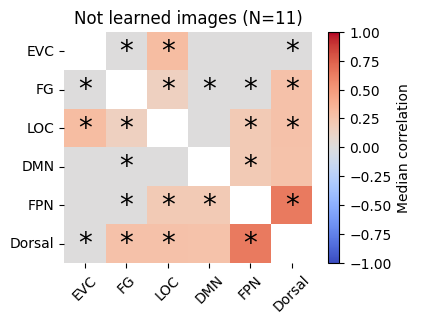

In [15]:
unlearned_mat, unlearned_p, rois = get_plot(df_rotate, 0, df)
fig, axis = plt.subplots(1, 1, figsize=(4, 3))

this_coef = unlearned_mat.copy()
p_mat = learned_p.copy()
this_name = "Not learned"

# Set the diagonal to nan
this_coef[np.eye(len(rois), dtype=bool)] = np.nan
heatmap1 = sns.heatmap(np.nanmedian(this_coef, axis=-1), cmap="coolwarm", vmin=-1, vmax=1, cbar=False, ax=axis)

# Number of images
n_imgs = (~np.isnan(this_coef[0, 1, :])).sum()

for i in range(p_mat.shape[1]):
    for j in range(p_mat.shape[0]):
        if np.isnan(p_mat[i, j]) or i == j:
            continue

        if p_mat[i, j] < 0.05:
            axis.text(i+0.5, j+0.5, "*", ha='center', va='center', color="black", fontsize=20)

axis.set_title(f"{this_name} images (N={n_imgs})")
axis.set_ylabel("")
axis.set_xlabel("")

# Set the ticks
axis.set_xticks(ticks=np.arange(len(rois)) + 0.5, labels=rois, rotation=45)
axis.set_yticks(ticks=np.arange(len(rois)) + 0.5, labels=rois, rotation=0)

# Create a colorbar to the right without being in 2nd axis
plt.colorbar(heatmap1.get_children()[0], ax=axis, orientation='vertical', label="Median correlation")

In [16]:
connection_df = {"connection": [], "subject": [], "corr": []}
for i in range(6):
    for j in range(i):
        for idx, s in enumerate(unlearned_mat[i, j, :]):
            if np.isnan(s):
                continue

            connection_df["connection"].append(f"{rois[i]}-{rois[j]}")
            connection_df["subject"].append(idx)
            connection_df["corr"].append(s)

connection_df = pd.DataFrame(connection_df)

res = smf.gee("corr ~ C(connection)", data=connection_df, groups="subject").fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                        corr   No. Observations:                  165
Model:                                 GEE   No. clusters:                       11
Method:                        Generalized   Min. cluster size:                  15
                      Estimating Equations   Max. cluster size:                  15
Family:                           Gaussian   Mean cluster size:                15.0
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Thu, 30 May 2024   Scale:                           0.165
Covariance type:                    robust   Time:                         10:52:14
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       0.0371      0.097      0.383      0.702      -0.153       0.227
C(connection)[T.DMN-FG]        -0.0309      0.195     -0.159      0.874      -0.413       0.351
C(connection)[T.DMN-LOC]        0.1440      0.156      0.920      0.357      -0.163       0.451
C(connection)[T.Dorsal-DMN]     0.2778      0.160      1.736      0.083      -0.036       0.592
C(connection)[T.Dorsal-EVC]     0.1478      0.109      1.357      0.175      -0.066       0.361
C(connection)[T.Dorsal-FG]      0.2380      0.130      1.834      0.067      -0.016       0.492
C(connection)[T.Dorsal-FPN]     0.4202      0.142      2.970      0.003       0.143       0.698
C(connection)[T.Dorsal-LOC]     0.3340      0.151      2.209      0.027       0.038       0.630
C(connection)[T.FG-EVC]         0.0398      0.114      0.350      0.726      -0.183       0.263
C(connection)[T.FPN-DMN]        0.3133      0.152      2.058      0.040       0.015       0.612
C(connection)[T.FPN-EVC]        0.0547      0.129      0.425      0.671      -0.197       0.307
C(connection)[T.FPN-FG]         0.0668      0.166      0.401      0.688      -0.259       0.393
C(connection)[T.FPN-LOC]        0.2472      0.139      1.775      0.076      -0.026       0.520
C(connection)[T.LOC-EVC]        0.2590      0.128      2.030      0.042       0.009       0.509
C(connection)[T.LOC-FG]         0.2966      0.155      1.919      0.055      -0.006       0.599
==============================================================================
Skew:                          0.1468   Kurtosis:                      -0.6699
Centered skew:                -0.3880   Centered kurtosis:              0.6377
==============================================================================
"""

In [17]:
m2_df = {'Connection': [], 'coef': [], 'ci_low': [], 'ci_high': [], 'p': []}
connections = ["DMN-FG", "DMN-LOC", "Dorsal-DMN", "Dorsal-EVC", "Dorsal-FG", "Dorsal-FPN", "Dorsal-LOC", "FG-EVC", "FPN-DMN", "FPN-EVC", "FPN-FG", "FPN-LOC", "LOC-EVC", "LOC-FG"]
starting_idx = 1
for roi_idx, conn in zip(range(starting_idx, len(connections) + starting_idx), connections):
    m2_df["Connection"].append(conn)

    m2_df["ci_low"].append(res.conf_int().iloc[roi_idx, 0])
    m2_df["ci_high"].append(res.conf_int().iloc[roi_idx, 1])
    m2_df["coef"].append(res.params[roi_idx])
    m2_df["p"].append(res.pvalues[roi_idx])

m2_df = pd.DataFrame(m2_df)
m2_df["q"] = false_discovery_control(m2_df["p"])
m2_df[m2_df["q"] < 0.05]

,Connection,coef,ci_low,ci_high,p,q
5,Dorsal-FPN,0.420209,0.142868,0.69755,0.002982,0.041745


## Reliability

In [70]:
# Remove images that are always recognized
df_volume = orig_df[orig_df["reliability"] != -1].copy()

# Remove images that are never recognized
df_volume = df_volume[df_volume["reliability"] >= 3/6]
df_volume["reliability"] = (df_volume["reliability"] - 1/2) * 2

df_volume["weights"] = df_volume["weights"].rank() / len(df_volume)

In [72]:
p1 = df_volume.pivot_table(index=["subject", "image_index"], columns="roi", values="weights").reset_index()
p1 = p1.join(df_volume.groupby(["subject", "image_index"])["reliability"].first(), on=["subject", "image_index"])

In [73]:
res = smf.gee("reliability ~ " + " + ".join(rois), data=p1, groups="subject", family=sm.families.Gamma(link=sm.families.links.Log())).fit()

In [74]:
fg_vals = [0.0, 0.5, 1]

others_val = {}
for roi in p1.columns:
    if roi in rois:
        others_val[roi] = [np.mean(p1[roi])] * len(fg_vals)

others_val["FG"] = fg_vals
res.predict(others_val)

0    0.744003
1    0.839700
2    0.947705
dtype: float64

0   -0.158761
1    0.241998
2   -0.061352
3   -0.086843
4    0.038152
5    0.017548
Name: coef, dtype: float64


Text(0.5, 0, "Info. strength's effect on learning reliability")

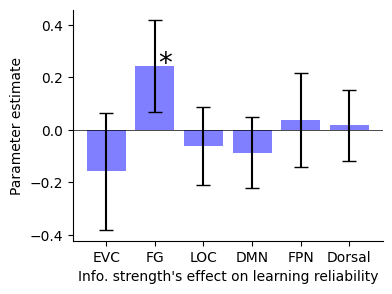

In [75]:
m2_df = {'ROI': [], 'coef': [], 'ci_low': [], 'ci_high': [], 'p': []}
starting_idx = 1
for roi_idx, roi in zip(range(starting_idx, len(rois) + starting_idx), rois):
    m2_df["ROI"].append(roi)

    m2_df["ci_low"].append(res.conf_int().iloc[roi_idx, 0])
    m2_df["ci_high"].append(res.conf_int().iloc[roi_idx, 1])
    m2_df["coef"].append(res.params[roi_idx])
    m2_df["p"].append(res.pvalues[roi_idx])

m2_df = pd.DataFrame(m2_df)
m2_df["q"] = false_discovery_control(m2_df["p"], method="bh")

# Assign order to ROI
m2_df["ROI"] = pd.Categorical(m2_df["ROI"], categories=rois, ordered=True)
m2_df = m2_df.sort_values("ROI").reset_index(drop=True)

print(m2_df["coef"])
plt.figure(figsize=(4, 3))

# Calculate the error bars as the difference from the estimate
m2_df['err_lower'] = m2_df['coef'] - m2_df['ci_low']
m2_df['err_upper'] = m2_df['ci_high'] - m2_df['coef']

plt.bar(m2_df.index, m2_df["coef"], yerr=[m2_df["err_lower"], m2_df["err_upper"]], capsize=5, color="b", alpha=0.5)
plt.xticks(m2_df.index, m2_df["ROI"])

# Draw star
for idx, row in m2_df.iterrows():
    if row["q"] < 0.05:
        plt.text(idx + 0.2, row["coef"] + 0.01, "*", ha='center', va='center', color="black", fontsize=20)
    elif row["p"] < 0.05:
        plt.text(idx + 0.2, row["coef"] + 0.01, "~", ha='center', va='center', color="black", fontsize=20)

plt.gca().spines[['top', 'right']].set_visible(False)
plt.axhline(0, color='black', linewidth=0.5)

plt.ylabel("Parameter estimate")
plt.xlabel("Info. strength's effect on learning reliability")

In [69]:
m2_df.to_dict()

{'ROI': {0: 'EVC', 1: 'FG', 2: 'LOC', 3: 'DMN', 4: 'FPN', 5: 'Dorsal'},
 'coef': {0: -0.048133060171526305,
  1: 0.09915576879948446,
  2: -0.04467760851329272,
  3: -0.04450499855179517,
  4: 0.009195265643315435,
  5: 0.0008919371168334128},
 'ci_low': {0: -0.13350760388084437,
  1: 0.013492062023306842,
  2: -0.10092250864132116,
  3: -0.1036912600819956,
  4: -0.06851989409728777,
  5: -0.05414647476736788},
 'ci_high': {0: 0.037241483537791754,
  1: 0.18481947557566208,
  2: 0.011567291614735714,
  3: 0.01468126297840526,
  4: 0.08691042538391865,
  5: 0.055930349001034704},
 'p': {0: 0.2691586065187318,
  1: 0.023289073297596195,
  2: 0.11949921730719038,
  3: 0.14053780526063697,
  4: 0.8166132464421609,
  5: 0.9746613497897002},
 'q': {0: 0.4037379097780977,
  1: 0.13973443978557717,
  2: 0.28107561052127394,
  3: 0.28107561052127394,
  4: 0.9746613497897002,
  5: 0.9746613497897002},
 'err_lower': {0: 0.08537454370931807,
  1: 0.08566370677617761,
  2: 0.056244900128028436,
  

### Learning

In [39]:
# Remove images that are always recognized
df_volume = orig_df[orig_df["learning"].isin([0, 1])].copy()

# Standardize
df_volume["weights"] = df_volume["weights"].rank() / len(df_volume)

In [41]:
p1 = df_volume.pivot_table(index=["subject", "image_index"], columns="roi", values="weights").reset_index()
p1 = p1.join(df_volume.groupby(["subject", "image_index"])["learning"].first(), on=["subject", "image_index"])

In [42]:
res = smf.gee("learning ~ " + " + ".join(rois), data=p1, groups="subject", family=sm.families.Binomial(sm.families.links.Logit())).fit()
res.summary()

/opt/anaconda3/envs/nature2023/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:            MixedLM Dependent Variable: learning 
No. Observations: 330     Method:             REML     
No. Groups:       19      Scale:              0.1293   
Min. group size:  9       Log-Likelihood:     -145.6037
Max. group size:  23      Converged:          Yes      
Mean group size:  17.4                                 
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     0.844    0.069 12.295 0.000  0.709  0.978
EVC          -0.077    0.088 -0.872 0.383 -0.250  0.096
FG           -0.015    0.103 -0.148 0.883 -0.216  0.186
LOC           0.099    0.093  1.066 0.287 -0.083  0.282
DMN           0.068    0.079  0.868 0.385 -0.086  0.223
FPN           0.134    0.097  1.380 0.168 -0.056  0.325
Dorsal       -0.334    0.099 -3.356 0.001 -0.528 -0.139
subject Var   0.007    0.014                           
=======================================================

"""

0   -0.077118
1   -0.015157
2    0.099408
3    0.068418
4    0.134235
5   -0.333558
Name: coef, dtype: float64


Text(0.5, 0, 'Info. strength effect on learning success')

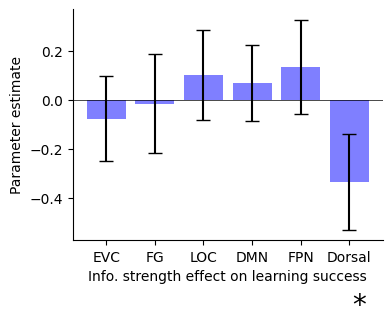

In [43]:
m2_df = {'ROI': [], 'coef': [], 'ci_low': [], 'ci_high': [], 'p': []}
starting_idx = 1
for roi_idx, roi in zip(range(starting_idx, len(rois) + starting_idx), rois):
    m2_df["ROI"].append(roi)

    m2_df["ci_low"].append(res.conf_int().iloc[roi_idx, 0])
    m2_df["ci_high"].append(res.conf_int().iloc[roi_idx, 1])
    m2_df["coef"].append(res.params[roi_idx])
    m2_df["p"].append(res.pvalues[roi_idx])

m2_df = pd.DataFrame(m2_df)
m2_df["q"] = false_discovery_control(m2_df["p"], method="bh")

# Assign order to ROI
m2_df["ROI"] = pd.Categorical(m2_df["ROI"], categories=rois, ordered=True)
m2_df = m2_df.sort_values("ROI").reset_index(drop=True)

print(m2_df["coef"])
plt.figure(figsize=(4, 3))

# Calculate the error bars as the difference from the estimate
m2_df['err_lower'] = m2_df['coef'] - m2_df['ci_low']
m2_df['err_upper'] = m2_df['ci_high'] - m2_df['coef']

plt.bar(m2_df.index, m2_df["coef"], yerr=[m2_df["err_lower"], m2_df["err_upper"]], capsize=5, color="b", alpha=0.5)
plt.xticks(m2_df.index, m2_df["ROI"])

# Draw star
for idx, row in m2_df.iterrows():
    if row["q"] < 0.05:
        plt.text(idx + 0.2, row["coef"] - 0.5, "*", ha='center', va='center', color="black", fontsize=20)

plt.gca().spines[['top', 'right']].set_visible(False)
plt.axhline(0, color='black', linewidth=0.5)

plt.ylabel("Parameter estimate")
plt.xlabel("Info. strength effect on learning success")

In [483]:
dorsal_vals = [0.0, 0.5, 1]

others_val = {}
for roi in p1.columns:
    if roi in rois:
        others_val[roi] = [np.mean(p1[roi])] * len(fg_vals)

others_val["Dorsal"] = fg_vals
res.predict(others_val)

0    0.923714
1    0.812824
2    0.608978
dtype: float64

In [484]:
m2_df.to_dict()

{'ROI': {0: 'EVC', 1: 'FG', 2: 'LOC', 3: 'DMN', 4: 'FPN', 5: 'Dorsal'},
 'coef': {0: -0.7768683794885921,
  1: -0.06602996743912762,
  2: 0.7979230793937735,
  3: 0.657090054876273,
  4: 0.6529151242342494,
  5: -2.05089453553969},
 'ci_low': {0: -1.7950065419592796,
  1: -1.494453156567454,
  2: -0.47907567377298244,
  3: -0.44764079275495594,
  4: -0.4335513209864509,
  5: -3.314510279439032},
 'ci_high': {0: 0.24126978298209523,
  1: 1.3623932216891987,
  2: 2.0749218325605296,
  3: 1.761820902507502,
  4: 1.7393815694549497,
  5: -0.7872787916403476},
 'p': {0: 0.134781842560865,
  1: 0.9278097548482808,
  2: 0.22070004372659413,
  3: 0.24370350991886314,
  4: 0.23885801657770522,
  5: 0.0014672042984605839},
 'q': {0: 0.29244421190263575,
  1: 0.9278097548482808,
  2: 0.29244421190263575,
  3: 0.29244421190263575,
  4: 0.29244421190263575,
  5: 0.008803225790763503},
 'err_lower': {0: 1.0181381624706876,
  1: 1.4284231891283263,
  2: 1.276998753166756,
  3: 1.104730847631229,
  4: